In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models, losses, backend, metrics
from sklearn.manifold import TSNE

In [2]:
# Process MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

mnist_train = np.reshape(x_train,(60000, 28, 28, 1))
mnist_train = np.tile(mnist_train, (1, 1, 1, 3))
mnist_test = np.reshape(x_test,(10000, 28, 28, 1))
mnist_test = np.tile(mnist_test, (1, 1, 1, 3))

In [3]:
# Load MNIST-M
mnistm = pkl.load(open('mnistm.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']

In [4]:
origin_1 = np.ones([mnist_train.shape[0], 1])
origin_2 = np.zeros([mnistm_train.shape[0], 1])
origins = np.vstack([origin_1, origin_2])

train = np.vstack([mnist_train, mnistm_train])

labels = np.tile(np.reshape(y_train, (-1, 1)), (2, 1))

# Normalizaing
train = train / 255.
mnist_test = mnist_test / 255.
mnistm_test = mnistm_test / 255.

In [5]:
print("train: {}".format(train.shape))
print("label: {}".format(labels.shape))
print("origin: {}".format(origins.shape))

train: (120000, 28, 28, 3)
label: (120000, 1)
origin: (120000, 1)


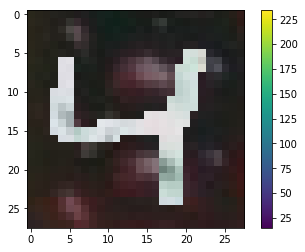

In [6]:
plt.figure()
plt.imshow(mnistm_train[2])
plt.colorbar()

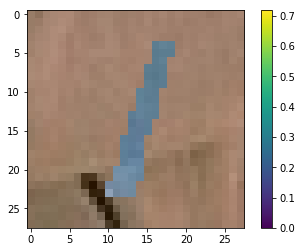

In [7]:
plt.figure()
plt.imshow(mnistm_test[2])
plt.colorbar()

In [8]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GRL(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

![mnist](mnist.png)
![a1](Algorithm1.png)

In [54]:
class MNISTModel(object):
    """Simple MNIST domain adaptation model."""
    def __init__(self):
        # models
        self.feature_model = self._feature_model()
        self.class_model = self._class_model()
        self.domain_model = self._domain_model()
        # losses & optimizer
        self.class_loss = losses.SparseCategoricalCrossentropy()
        self.domain_loss = losses.BinaryCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.SGD()
        # trainable variables
        self.tvars = list(set(self.class_model.trainable_weights + self.domain_model.trainable_weights))
    
    def _feature_model(self):
        model = tf.keras.models.Sequential()
        model.add(layers.Conv2D(32, (5, 5),
                                activation='relu',
                                input_shape=(28, 28, 3),
                                padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
#         model.add(layers.BatchNormalization())
        
        model.add(layers.Conv2D(48, (5, 5),
                                activation='relu',
                                padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
#         model.add(layers.BatchNormalization())
        
        model.add(layers.Dense(10, activation='relu'))
        return model
    
    def _class_model(self):
        model = tf.keras.models.Sequential()
        model.add(self.feature_model)
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(10))
        model.add(layers.Softmax())
        return model
    
    def _domain_model(self):
        model = tf.keras.models.Sequential()
        model.add(self.feature_model)
        model.add(GRL()) # reverse the gradient
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(1))
        return model
    
#     @tf.function
    def train_dann(self, images, labels, origins, p):
        # learning-rate
        lr = 0.01 / tf.math.pow((1 + 10*p), 0.75)
        
        # domain adaptation parameter
        dap = (2 / (1 + tf.math.exp(-10 * p))) - 1
        
        # source masking
        mask = tf.dtypes.cast(tf.reshape(origins, (-1,)), tf.bool)
        x_able = tf.boolean_mask(images, mask)
        y_able = tf.boolean_mask(labels, mask)
        
        # forward prop
        with tf.GradientTape() as tape:
            pred_class = self.class_model(x_able)
            loss_class = self.class_loss(y_able, pred_class)
            
            pred_domain = self.domain_model(images)
            loss_domain = self.domain_loss(origins, pred_domain)
            
            total_loss = loss_class + (dap * loss_domain)
        
        # only feature 
        grads = tape.gradient(total_loss, self.tvars)
        
        # update
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr,
                                                 momentum=0.9)
        optimizer.apply_gradients(zip(grads, self.tvars))
        
        return loss_class, loss_domain, lr, dap

    def train_asis(self, images, labels):
        self.class_model.compile(self.optimizer, self.class_loss, metrics=['accuracy'])
        self.class_model.fit(images, labels, epochs=1, batch_size=64)

In [55]:
dann = MNISTModel()
nn = MNISTModel()

In [16]:
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices(
    (train.astype('float32'), labels, origins)).shuffle(train.shape[0]).batch(batch_size)

In [87]:
train_loss_domain = []
train_loss_class = []

def train_n_epoch(n):
    for e in range(n):
        predc, predd, target = [], [], []
        epoch_loss_domain = metrics.Mean()
        epoch_loss_class = metrics.Mean()

        for train_b, label_b, origin_b in train_ds:
            lc, ld, lr, dap = dann.train_dann(train_b, label_b, origin_b, (e+1)/n)

            mask = tf.dtypes.cast(tf.reshape(origin_b, shape=[-1]), tf.bool)
            x_able = tf.boolean_mask(train_b, mask)
            y_able = tf.boolean_mask(label_b, mask)

            predc = np.append(predc, np.argmax(dann.class_model.predict(x_able), axis=1))
            predd = np.reshape(list(map(lambda x: 1 if x>=0.5 else 0, 
                                        dann.domain_model(train_b).numpy())), (-1, 1))

            target = np.append(target, y_able)

            epoch_loss_class(lc)
            epoch_loss_domain(ld)

        train_loss_class.append(epoch_loss_class.result())
        train_loss_domain.append(epoch_loss_domain.result())

        print("<Train>", end=' ')
        print("LR: {:.4}".format(lr), end=' ')
        print("DAP: {:.4}".format(dap), end=' || ')
        print("Class Loss: {:.4}".format(epoch_loss_class.result()), end=' || ')
        print("Domain Loss: {:.4}".format(epoch_loss_domain.result()), end=' || ')
        print("Class Accuracy: {:.2%}".format(np.sum(predc == np.reshape(target, (-1))) / len(predc)))
        print("Domain Accuracy: {:.2%}".format(np.asscalar(sum(origin_b.numpy() == predd) / len(predd))))
        
        dann.class_model.evaluate(mnist_test, np.reshape(y_test, (-1, 1)))
        dann.class_model.evaluate(mnistm_test, np.reshape(y_test, (-1, 1)))

In [88]:
dann.class_model.compile(dann.optimizer, dann.class_loss, metrics=['accuracy'])
train_n_epoch(4)

<Train> LR: 0.003908 DAP: 0.8483 || Class Loss: 0.3044 || Class Loss: 0.3044 || Domain Loss: 0.6262 || Class Accuracy: 92.88%
Domain Accuracy: 67.19%
10000/10000 [==============================] - 3s 297us/sample - loss: 4.1548 - accuracy: 0.3203
<Train> LR: 0.002608 DAP: 0.9866 || Class Loss: 0.2364 || Class Loss: 0.2364 || Domain Loss: 0.6142 || Class Accuracy: 94.43%
Domain Accuracy: 73.44%
10000/10000 [==============================] - 3s 294us/sample - loss: 6.8539 - accuracy: 0.2930
<Train> LR: 0.002009 DAP: 0.9989 || Class Loss: 0.21 || Class Loss: 0.21 || Domain Loss: 0.6115 || Class Accuracy: 94.94%
Domain Accuracy: 60.94%
10000/10000 [==============================] - 3s 309us/sample - loss: 5.4237 - accuracy: 0.3059
<Train> LR: 0.001656 DAP: 0.9999 || Class Loss: 0.1942 || Class Loss: 0.1942 || Domain Loss: 0.6116 || Class Accuracy: 95.25%
Domain Accuracy: 64.06%
10000/10000 [==============================] - 3s 308us/sample - loss: 3.7376 - accuracy: 0.3439


In [89]:
mask = tf.dtypes.cast(backend.reshape(origins, shape=[-1]), tf.bool)
x_able = tf.boolean_mask(train, mask)
y_able = tf.boolean_mask(labels, mask)

# train nn
for _ in range(4):
    history = nn.train_asis(x_able, y_able)
    nn.class_model.evaluate(mnist_test, y_test)
    nn.class_model.evaluate(mnistm_test, y_test)

10000/10000 [==============================] - 3s 310us/sample - loss: 2.5658 - accuracy: 0.2008


In [90]:
# Create a mixed dataset for TSNE visualization
num_test = 500
combined_test_imgs = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])

y_test2 = y_test.reshape(-1,1)
combined_test_labels = np.vstack([y_test2[:num_test], y_test2[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
                                  np.tile([0., 1.], [num_test, 1])])

In [91]:
dann_emb = dann.feature_model(combined_test_imgs.astype('float32'))
tsne_d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dann_tsne = tsne_d.fit_transform(dann_emb)

In [92]:
nn_emb = nn.feature_model(combined_test_imgs.astype('float32'))
tsne_n = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
nn_tsne = tsne_n.fit_transform(nn_emb)

In [93]:
n = combined_test_labels.reshape(-1).astype('str')
z = dann_tsne[:,0]
y = dann_tsne[:,1]
z2 = nn_tsne[:,0]
y2 = nn_tsne[:,1]

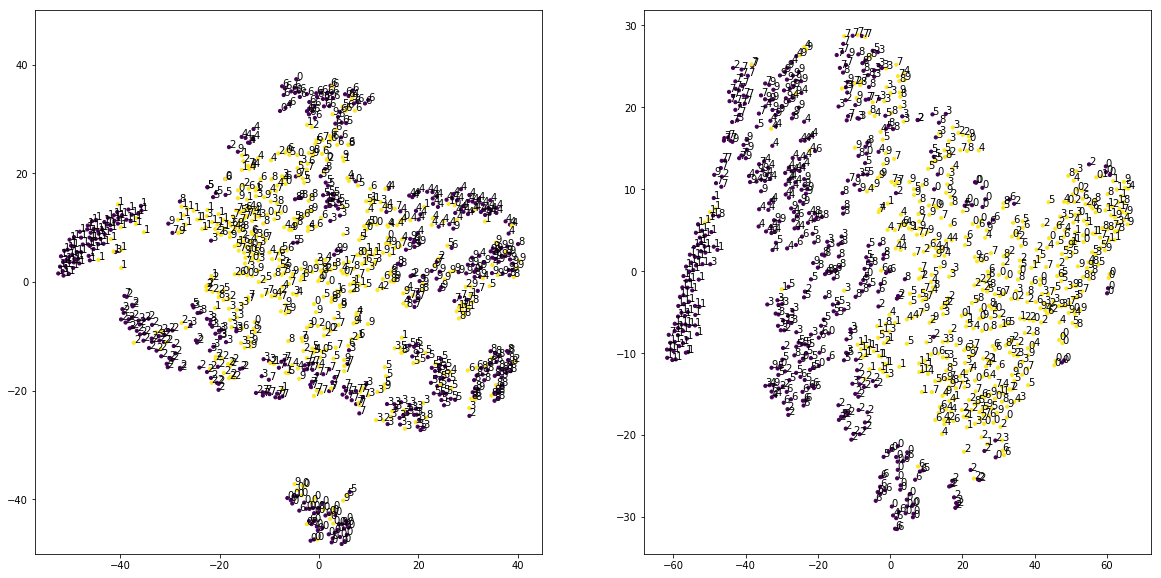

In [94]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(z, y, c=combined_test_domain.argmax(1), s=10)
for i, txt in enumerate(n):
    ax1.annotate(txt, (z[i], y[i]))
# ax1.set_xlim(-50,50)
ax1.set_ylim(-50,50)

ax2 = fig.add_subplot(1,2,2)
# ax2.set_xlim(-50,50)
# ax2.set_ylim(-50,50)
ax2.scatter(z2, y2, c=combined_test_domain.argmax(1), s=10)
for i, txt in enumerate(n):
    ax2.annotate(txt, (z2[i], y2[i]))